In [4]:
import findspark
findspark.init()

In [5]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.streaming import StreamingContext
import sys
import time
import re
from textblob import *
from pybloom_live import BloomFilter
from langdetect import detect, detect_langs
import pandas as pd

In [6]:
# Create a SparkSession
spark = SparkSession \
        .builder \
        .appName("TwitterStream") \
        .master("192.168.6.239:7077") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/20 15:36:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Create a streaming DataFrame that represents text data received from a server
raw_tweets = spark \
        .readStream \
        .format("socket") \
        .option("host", "localhost") \
        .option("port", 19013) \
        .load()

23/01/19 19:51:33 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [7]:
# Create a function to return the tweet language, returns "unknown" if it can't detect the language
def getLang(tweet: str) -> str:
    try:
        return detect(tweet)
    except:
        return "unknown"

# udf to get the tweet language
language = F.udf(getLang, StringType())

In [8]:
# Create a bloom filter to filter out duplicate tweets
bloom_filter = BloomFilter(capacity=100000, error_rate=0.001)

# Define a function to identify if tweets are already in the bloom filter
udf_bloom_filter = udf(lambda x: x in bloom_filter, BooleanType())

In [9]:
# this and some other preprocessing measures based on code from 
# https://medium.com/@lorenagongang/sentiment-analysis-on-streaming-twitter-data-using-kafka-spark-structured-streaming-python-part-b27aecca697a

# cleaning the tweet text

def cleanTweet(tweet: str) -> str:
    tweet = re.sub(r'http\S+', '', str(tweet))
    tweet = re.sub(r'bit.ly/\S+', '', str(tweet))
    tweet = tweet.strip('[link]')

    # remove users
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))

    # remove puntuation
    my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'
    tweet = re.sub('[' + my_punctuation + ']+', ' ', str(tweet))

    # remove number
    tweet = re.sub('([0-9]+)', '', str(tweet))

    # remove hashtag
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))

    return tweet

# udf to clean the tweet
cleaning = F.udf(cleanTweet, StringType())

In [10]:
# Create a function to get the subjectivity
def getSubjectivity(tweet: str) -> float:
    return TextBlob(tweet).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(tweet: str) -> float:
    return TextBlob(tweet).sentiment.polarity

# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getSentiment(polarityValue: int) -> str:
    if polarityValue < 0:
        return 'Negative'
    elif polarityValue == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [11]:
# split the stream into individual rows by splitting on end of tweet text
raw_tweets = raw_tweets.select(split(raw_tweets.value, """!ENDOFTWEET!""").alias("tweets"))

# create a new DataFrame with a separate row for each element in the 'tweets' column
tweets_df = raw_tweets.select(explode(raw_tweets.tweets).alias("tweet"))

# clean the tweets
tweets_df = tweets_df.withColumn("clean_tweet", cleaning(col("tweet")))

# filter out tweets with less than 3 characters
tweets_df = tweets_df.filter(length(col("clean_tweet")) > 3)

# identify the language of the tweet, append to a new column, and filter out non-english tweets
tweets_df = tweets_df.withColumn("lang", language(col("clean_tweet")))
tweets_df = tweets_df.filter(col("lang") == "en")

# filter for reweets
tweets_df.filter(~(col("clean_tweet").startswith("RT") | col("clean_tweet").startswith("rt")))

# identify duplicate tweets and append a new column
tweets_df = tweets_df.withColumn("duplicate", udf_bloom_filter(col("clean_tweet")))

In [12]:
# add the sentiment columns
subjectivity = F.udf(getSubjectivity, FloatType())
polarity = F.udf(getPolarity, FloatType())
sentiment = F.udf(getSentiment, StringType())

tweets_df = tweets_df.withColumn("subjectivity", subjectivity(col("clean_tweet")))
tweets_df = tweets_df.withColumn("polarity", polarity(col("clean_tweet")))
tweets_df = tweets_df.withColumn("sentiment", sentiment(col("polarity")))

In [13]:
# query which writes to a cumulative parquet file
query = tweets_df \
        .writeStream \
        .queryName("tweet stream") \
        .outputMode("append") \
        .format("parquet") \
        .option("path", "outputs/twitter_stream") \
        .option("checkpointLocation", "outputs/twitter_stream/checkpoint") \
        .start()

23/01/19 19:51:36 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [ ]:
# show header of parquet file
spark.read.parquet("outputs/twitter_stream").show()

In [ ]:
# count rows in parquet file
spark.read.parquet("outputs/twitter_stream").count()

In [ ]:
# retrieve number of rows in parquet file. When 10000 rows are reached, stop the query
while spark.read.parquet("outputs/twitter_stream").count() < 150000:
    time.sleep(60)
    print(spark.read.parquet("outputs/twitter_stream").count())
else:
    print("150000 rows reached")
    query.stop()

In [7]:
# convert the parquet file to a pandas dataframe
df = spark.read.parquet("outputs/twitter_stream").toPandas()

# show the dataframe
df.head()

,tweet,clean_tweet,lang,duplicate,subjectivity,polarity,sentiment
0,🔹MORTI IN CINA…,🔹MORTI IN CINA…,en,False,0.000000,0.000000,Neutral
1,This #Sales job might be a great fit for you. ...,This job might be a great fit for you Click ...,en,False,0.550000,0.566667,Positive
2,RT @nbreavington: BREAKING NEWS: Top U.S. Doct...,BREAKING NEWS Top U S Doctor warns none of...,en,False,0.500000,0.500000,Positive
3,"If jobs with titles like ""Security Officer Fin...",If jobs with titles like Security Officer Fin...,en,False,0.250000,0.200000,Positive
4,Stop staring at the clock every day. It's time...,Stop staring at the clock every day It s time...,en,False,0.454545,0.136364,Positive


In [8]:
# show the content of clean_tweet index 0
df['clean_tweet'][6]

'  Do not be fooled by this phony  The real DeSantis lures immigrants onto planes with false promises and dumps them in o…'

In [9]:
# length of the dataframe
len(df)

137918

In [10]:
# apply emotion analysis to the tweets using distilbert to extract emotional categories of joy, anger and sadness, and the probability of each category
from transformers import pipeline

classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', top_k=1, )

# function to return the emotional analysis label
def getEmotion(tweet: str):
    result = classifier(tweet)
    label = result[0][0]['label']
    score = result[0][0]['score']
    return pd.Series([label, score])

# apply the function to the dataframe
df[['emotion', 'score']] = df['clean_tweet'].apply(getEmotion)

In [11]:
# show df head
df.head()

,tweet,clean_tweet,lang,duplicate,subjectivity,polarity,sentiment,emotion,score
0,🔹MORTI IN CINA…,🔹MORTI IN CINA…,en,False,0.000000,0.000000,Neutral,anger,0.459923
1,This #Sales job might be a great fit for you. ...,This job might be a great fit for you Click ...,en,False,0.550000,0.566667,Positive,joy,0.985426
2,RT @nbreavington: BREAKING NEWS: Top U.S. Doct...,BREAKING NEWS Top U S Doctor warns none of...,en,False,0.500000,0.500000,Positive,joy,0.992289
3,"If jobs with titles like ""Security Officer Fin...",If jobs with titles like Security Officer Fin...,en,False,0.250000,0.200000,Positive,joy,0.998692
4,Stop staring at the clock every day. It's time...,Stop staring at the clock every day It s time...,en,False,0.454545,0.136364,Positive,joy,0.959309


In [12]:
import pandas as pd
import unicodedata
import re
import contractions
import string
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#spacy
import spacy
from nltk.corpus import stopwords


# Based on https://medium.com/mlearning-ai/topic-modelling-with-lda-on-the-tweets-mentioning-elon-musk-687076a2c86b

# Preprocess the original tweet text

# convert to lowercase in a new clean_tweet column
temp_df = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# remove accented characters
temp_df = temp_df.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

# remove URLs
temp_df = temp_df.apply(lambda x: re.sub(r"http\S+", "", x))

# expand contractions for each word in the tweet
temp_df = temp_df.apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))

# remove mentions, hashtags, and retweets
temp_df = temp_df.apply(lambda x: re.sub(r'@\w+|\#|\brt\b', '', x))

# remove punctuation and special characters
temp_df = temp_df.apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

# remove stopwords
stop = stopwords.words('english')
# add COVID to the stopwords list
stop.append('covid')
temp_df = temp_df.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# remove words with less than 3 characters
temp_df = temp_df.apply(lambda x: " ".join(x for x in x.split() if len(x) > 3))

# lemmatize the tweets
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
temp_df = temp_df.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

# convert to df
temp_df = pd.DataFrame(temp_df)

#show the dataframe
temp_df.head()


,tweet
0,morti
1,sale might great click link communication sale...
2,break doctor warn none vaccine safe must pull ...
3,job title like officer financial sound appeal ...
4,stop stare clock every time follow view job ti...


In [13]:
# function to extract tokens from tweets
def generate_tokens(text):
    words = []
    for word in text.split():
        if word!='':
            words.append(word)
    return words

# create a new column with the tokens
temp_df['tokens'] = temp_df['tweet'].apply(lambda x: generate_tokens(x))

# show the dataframe
temp_df.head()

,tweet,tokens
0,morti,[morti]
1,sale might great click link communication sale...,"[sale, might, great, click, link, communicatio..."
2,break doctor warn none vaccine safe must pull ...,"[break, doctor, warn, none, vaccine, safe, mus..."
3,job title like officer financial sound appeal ...,"[job, title, like, officer, financial, sound, ..."
4,stop stare clock every time follow view job ti...,"[stop, stare, clock, every, time, follow, view..."


In [14]:
# create bigrams and trigrams
bigram = gensim.models.Phrases(temp_df['tokens'], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[temp_df['tokens']], threshold=100)

# create bigram and trigram models
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# apply the bigram and trigram models to the tokens
temp_df['tokens'] = temp_df['tokens'].apply(lambda x: bigram_mod[x])
temp_df['tokens'] = temp_df['tokens'].apply(lambda x: trigram_mod[bigram_mod[x]])

# create dictionary and corpus
id2word = corpora.Dictionary(temp_df['tokens'])
texts = temp_df['tokens']
corpus = [id2word.doc2bow(text) for text in texts]

# show the dictionary
print(id2word)
# show the corpus
print(temp_df['tokens'][0])

Dictionary<35344 unique tokens: ['morti', 'click_link', 'communication', 'great', 'marketsource']...>
['morti']


In [15]:
# build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, 
                                            random_state=100, update_every=1, chunksize=100, 
                                            passes=10, alpha='auto', per_word_topics=True)


In [16]:
# explore the topic model to find optimal number of topics

import os
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

os.environ["TOKENIZERS_PARALLELISM"] = "false"

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/home/ubuntu/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.285109 -0.098330       1        1  49.757549
0     -0.236840 -0.173841       2        1  33.430336
2     -0.048269  0.272171       3        1  16.812115, topic_info=                         Term          Freq         Total Category  logprob  \
11                    vaccine   8942.000000   8942.000000  Default  30.0000   
1                  click_link  13872.000000  13872.000000  Default  29.0000   
44                      death   7117.000000   7117.000000  Default  28.0000   
221                     would   4067.000000   4067.000000  Default  27.0000   
662             facebook_file   6054.000000   6054.000000  Default  26.0000   
...                       ...           ...           ...      ...      ...   
134                     level    530.442630    532.375862   Topic3  -5.4049   
22                 government    533.357028    535.316238   Topic3  -5.3994   
1436  silence_yuval_noah_hide    534.605860    536.689626   Topic3  -5.3971   
1095                     kill    908.642614   1629.715992   Topic3  -4.8666   
112                       say   1185.462417   2987.694814   Topic3  -4.6007   

      loglift  
11    30.0000  
1     29.0000  
44    28.0000  
221   27.0000  
662   26.0000  
...       ...  
134    1.7794  
22     1.7794  
1436   1.7792  
1095   1.1989  
112    0.8587  

[129 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
106       1  0.000821                    also
106       2  0.998536                    also
106       3  0.000821                    also
968       1  0.000731                 another
968       2  0.998496                 another
...     ...       ...                     ...
183       2  0.000496                    year
183       3  0.000496                    year
6238      1  0.000587  zealand_jacinda_ardern
6238      2  0.000587  zealand_jacinda_ardern
6238      3  0.998640  zealand_jacinda_ardern

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [17]:
# calculate the current coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4656286836877374


In [18]:
# function to get the lda topics
def get_lda_topics(model, num_topics, topn):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = topn)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

# show the topics
get_lda_topics(lda_model, 3, 20)

,Topic # 01,Topic # 02,Topic # 03
0,click_link,card,vaccine
1,facebook_file,censorship,death
2,scam,fake_datum,would
3,like,need,laugh
4,netflix_propaganda,real,confirm
5,still,money,never
6,tell,people,live
7,look,thank,zealand_jacinda_ardern
8,australia_scott_morrison,know,shot
9,rate,miss,state


In [23]:
# bar chart of volume of tweets by topic
import matplotlib.pyplot as plt
import seaborn as sns
import builtins

# get the topics
topic_distribution = [lda_model.get_document_topics(tweet) for tweet in corpus]

# add topic to the dataframe
df['topic'] = [builtins.max(topic, key=lambda item:item[1])[0] for topic in topic_distribution]

# group by topic
topic_counts = df.groupby('topic').size().reset_index(name='counts')

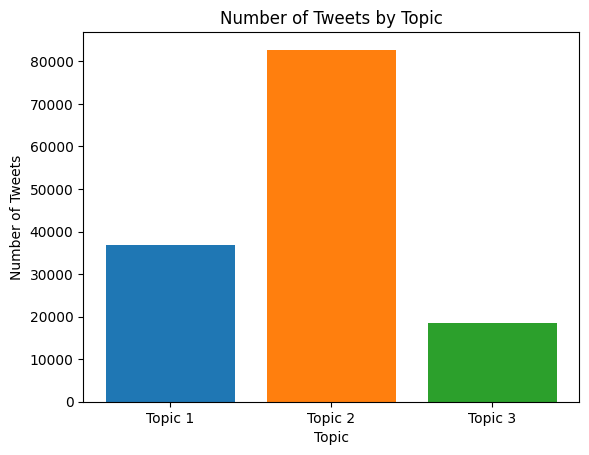

In [28]:
# plot the topics with seaborn color palette
colours = sns.color_palette("tab10", n_colors=6)

plt.bar(topic_counts['topic'], topic_counts['counts'], color=colours[0:3])
x_labels = ['Topic 1', 'Topic 2', 'Topic 3']
plt.xticks(topic_counts['topic'], x_labels)
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Topic')
plt.show()

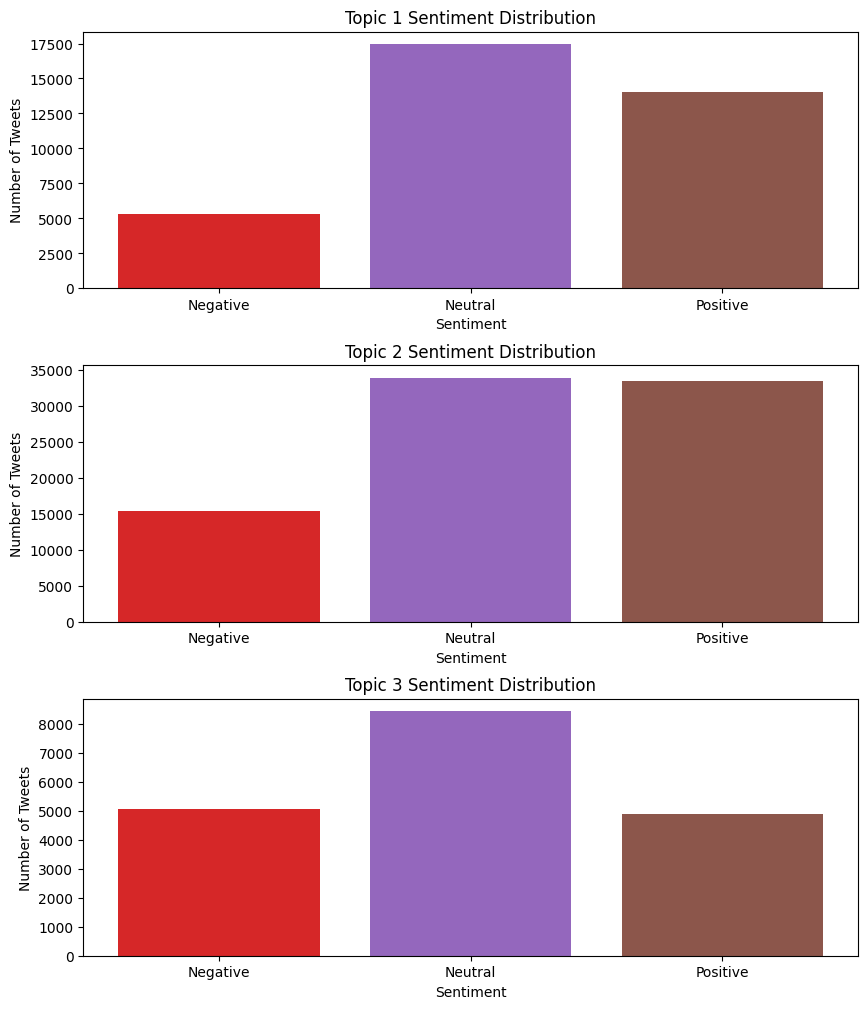

In [25]:
# bar chart of split of tweets by sentiment and topic

# group the tweets by topic and sentiment
topic_sentiment_counts = df.groupby(["topic", "sentiment"]).size().reset_index(name='counts')

# create a list of unique topics
topics = topic_sentiment_counts["topic"].unique()

# create a subplot for each topic
fig, axs = plt.subplots(len(topics), 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.3)


# iterate over each topic
for i, topic in enumerate(topics):
    # filter the DataFrame for the current topic
    topic_data = topic_sentiment_counts[topic_sentiment_counts["topic"] == topic]

    # plot the bar chart for the current topic, with colors based on negative, neutral and positive
    axs[i].bar(topic_data["sentiment"], topic_data["counts"], color=colours[3:6])
    axs[i].set_title(f"Topic {i+1} Sentiment Distribution")
    axs[i].set_xlabel("Sentiment")
    axs[i].set_ylabel("Number of Tweets")
plt.show()

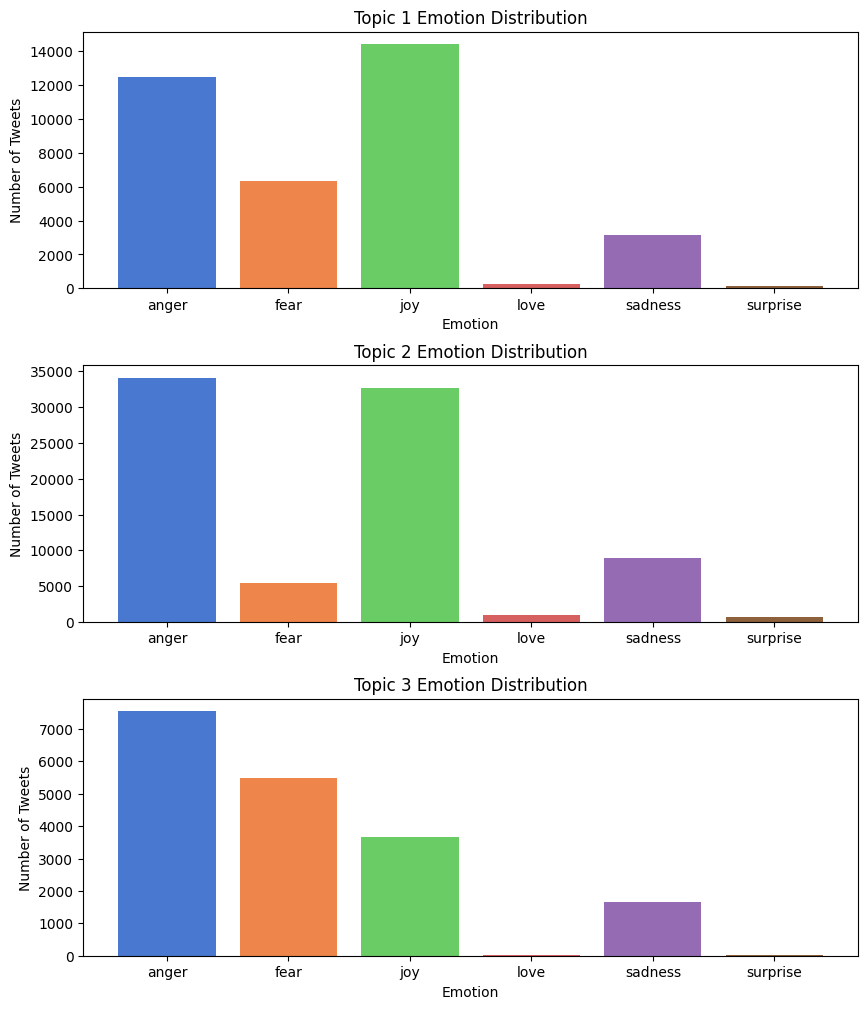

In [26]:
# bar chart of split of tweets by emotion and topic

# group the tweets by topic and emotion
topic_emotion_counts = df.groupby(["topic", "emotion"]).size().reset_index(name='counts')

# create a list of unique topics
topics = topic_emotion_counts["topic"].unique()

# create a subplot for each topic
fig, axs = plt.subplots(len(topics), 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.3)

# iterate over each topic
for i, topic in enumerate(topics):
    # filter the DataFrame for the current topic
    topic_data = topic_emotion_counts[topic_emotion_counts["topic"] == topic]

    # plot the bar chart for the current topic, with seaborn colors
    axs[i].bar(topic_data["emotion"], topic_data["counts"], color=sns.color_palette("muted"))
    axs[i].set_title(f"Topic {i+1} Emotion Distribution")
    axs[i].set_xlabel("Emotion")
    axs[i].set_ylabel("Number of Tweets")
plt.show()

In [36]:
# df head
df.head()

,tweet,clean_tweet,lang,duplicate,subjectivity,polarity,sentiment,emotion,score,topic
0,🔹MORTI IN CINA…,🔹MORTI IN CINA…,en,False,0.000000,0.000000,Neutral,anger,0.459923,0
1,This #Sales job might be a great fit for you. ...,This job might be a great fit for you Click ...,en,False,0.550000,0.566667,Positive,joy,0.985426,0
2,RT @nbreavington: BREAKING NEWS: Top U.S. Doct...,BREAKING NEWS Top U S Doctor warns none of...,en,False,0.500000,0.500000,Positive,joy,0.992289,2
3,"If jobs with titles like ""Security Officer Fin...",If jobs with titles like Security Officer Fin...,en,False,0.250000,0.200000,Positive,joy,0.998692,0
4,Stop staring at the clock every day. It's time...,Stop staring at the clock every day It s time...,en,False,0.454545,0.136364,Positive,joy,0.959309,0


In [39]:
# Gauge confidence of emotion analysis

# display average of df.score per topic
df.groupby('topic').agg({'score': 'mean'})

,score
topic,
0,0.777276
1,0.810537
2,0.809484


In [31]:
# save the dataframe to a csv file on GCS
from google.cloud import storage

path_to_private_key = '/home/ubuntu/Twitter_Stream/root-melody-375315-2d27496729b5.json'

client = storage.Client.from_service_account_json(path_to_private_key)

# The bucket on GCS in which to write the CSV file
bucket = client.get_bucket('ssp_twitter_stream')

# The name assigned to the CSV file on GCS
blob = bucket.blob('twitter_stream_data.csv')
blob.upload_from_string(df.to_csv(), 'text/csv')

# Can be queried using Google Big Query at a later point while maintaining single file integrity for individual examination


In [35]:
# save the dataframe to a csv file in the local Ubuntu folder
#df.to_csv('/home/ubuntu/Twitter_Stream/twitter_stream_data.csv', index=False)